In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import AzureOpenAI

In [3]:
load_dotenv(override=True)
api_key = os.getenv('AZURE_OPENAI_API_KEY')
api_base = os.getenv("AZURE_OPENAI_ENDPOINT") 


azureai = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=api_base,
    api_version="2023-12-01-preview" 
)

MODEL = "gpt-4o-mini"
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:

# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $319.97 Error: $199.97 SLE: 0.95 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $80.00 Truth: $184.99 Error: $104.99 SLE: 0.69 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $35.00 Truth: $193.39 Error: $158.39 SLE: 2.84 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $350.00 Truth: $153.99 Error: $196.01 SLE: 0.67 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $75.00 Truth: $156.83 Error: $81.83 SLE: 0.53 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $12.00 Truth: $339.00 Error: $327.00 SLE: 10.65 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $115.00 Truth: $17.99 Error: $97.01 SLE: 3.27 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $100.00 Truth: $180.75 Error: $80.75 SLE: 0.35 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $300.00 Truth: $248.35 Error: $51.65 SLE: 0.04 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $80.00 Truth: $98.95 Error: $18.95 SLE:

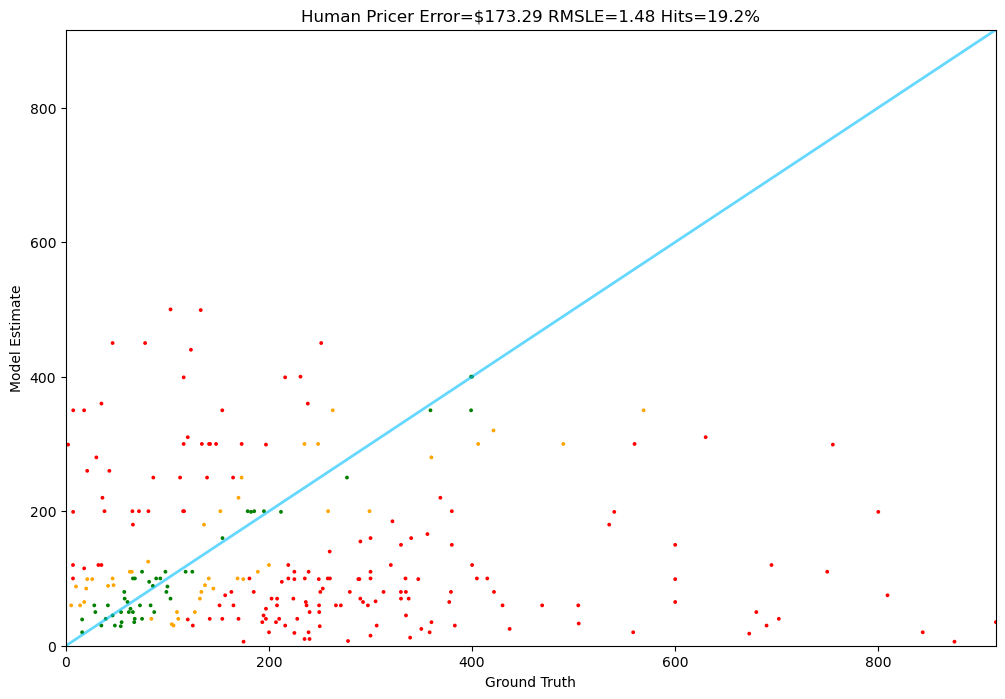

In [11]:
Tester.test(human_pricer, test)

In [12]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [14]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [15]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = azureai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [16]:
test[0].price

319.97

1: Guess: $200.00 Truth: $319.97 Error: $119.97 SLE: 0.22 Item: Cetol SRD Natural - 5 Gallons
2: Guess: $199.00 Truth: $184.99 Error: $14.01 SLE: 0.01 Item: Rhino-Rack Aluminum Roof Rack Tracks 58....
3: Guess: $66.47 Truth: $193.39 Error: $126.92 SLE: 1.12 Item: Delta Faucet 51600-SSN/An/A Includes 60"...
4: Guess: $120.00 Truth: $153.99 Error: $33.99 SLE: 0.06 Item: Texan Auto Seat Cover - Driver Bottom Le...
5: Guess: $99.99 Truth: $156.83 Error: $56.84 SLE: 0.20 Item: Dawn Enterprises FE2-4RUN Finished End B...
6: Guess: $89.99 Truth: $339.00 Error: $249.01 SLE: 1.74 Item: DIDER 22'' Farmhouse Ceiling Fan with Li...
7: Guess: $24.99 Truth: $17.99 Error: $7.00 SLE: 0.10 Item: Floor Lamp Shade 2 Pack Torchiere Lamp S...
8: Guess: $150.00 Truth: $180.75 Error: $30.75 SLE: 0.03 Item: OE Wheels LLC TY09-17075-6550-30MS Silve...
9: Guess: $35.00 Truth: $248.35 Error: $213.35 SLE: 3.75 Item: Taco 0011-009RP Series Replacement Cartr...
10: Guess: $150.00 Truth: $98.95 Error: $51.05 SLE: 0.

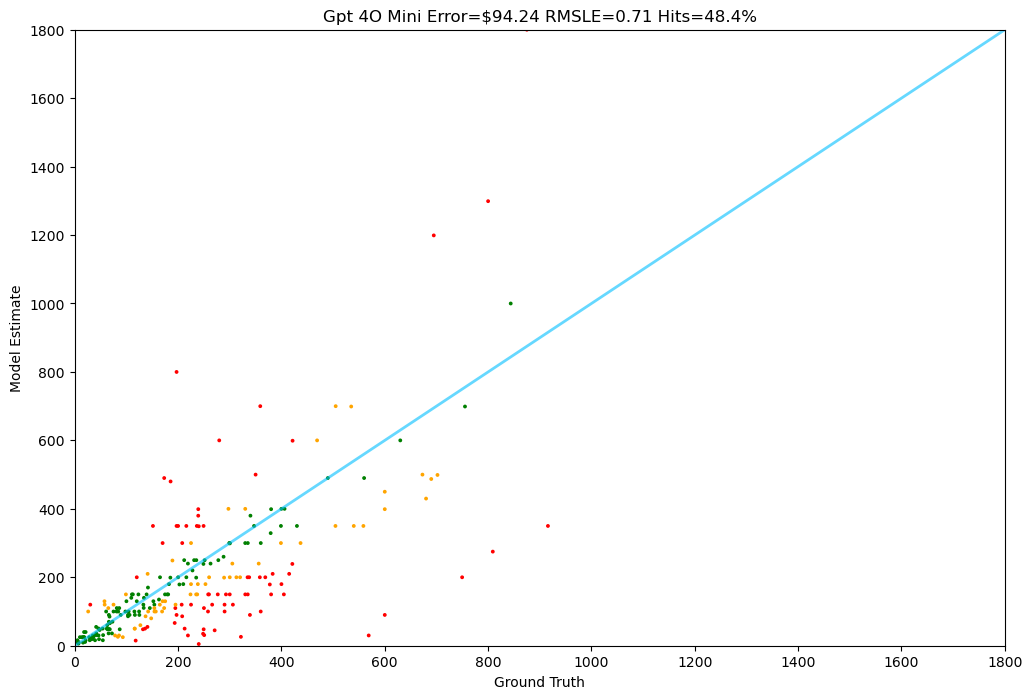

In [17]:
Tester.test(gpt_4o_mini, test)